In [426]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd

In [427]:
def random_antenna_pos(x_lims = 1000, y_lims =1000):
    return rnd.random_sample(2)*np.array([x_lims,y_lims]) - np.array([x_lims, y_lims])/2

In [457]:
def radial_antenna_arr(n_antenna= 3, x_lims=1000, y_lims=1000, r=300):
    return np.array([[np.cos(angle)*r, np.sin(angle)*r] for angle in [2*np.pi/n_antenna*i for i in range(n_antenna)]])

In [429]:
def y_antenna_arr(n_antenna=5, r=500, alpha=0):
    step = r/n_antenna
    return np.array([ [np.array([(i+1)*step*np.cos(angle/180*np.pi), (i+1)*step*np.sin(angle/180*np.pi)]) for i in range(n_antenna)] for angle in [alpha, alpha+120, alpha+240] ]).reshape((3*n_antenna,2))


In [430]:
def random_antenna_arr(n_antenna=3, x_lims=1000, y_lims=1000):
    return np.array([random_antenna_pos(x_lims, y_lims) for i in range(n_antenna)])

In [431]:
def get_baselines(array):
    # Get the baseline for every combination of antennas i-j.
    # Remove the i=j baselines: np.delete(array, list, axis=0) -> delete the rows listed on 'list' from array 'array'. 
    return np.delete(np.array([antenna_i-antenna_j for antenna_i in array for antenna_j in array]), [(len(array)+1)*n for n in range(len(array))], 0)

In [788]:
def uv_time_int(baselines, array_latitud=35/180*np.pi,source_declination=35/180*np.pi, track_time=8, delta_t=5/60, t_0=-2):
    # visibility rotation matrix
    def M(h):
        return np.array([[np.sin(h/12*np.pi), -np.cos(h/12*np.pi), 0],
                        [-np.sin(source_declination)*np.cos(h/12*np.pi), -np.sin(source_declination)*np.sin(h/12*np.pi), np.cos(source_declination)]])
    # Baseline transformation from (north,east,elev=0) to (x,y,z)
    B = np.array([[-np.sin(array_latitud) , 0],
            [0 , -1],
            [np.cos(array_latitud) , 0]])

    n_samples = int(track_time/delta_t)
    track = []
    for t in range(n_samples):
        track.append(baselines.dot(B.T).dot(M(t_0+t*delta_t).T))
    return np.array(track).reshape((-1,2))



In [789]:
def get_uv_plane(baseline, uv_dim=128):
    # Count number of samples per uv grid
    x_lim=max(abs(baseline[:,0]))*1.1
    y_lim=max(abs(baseline[:,1]))*1.1
    uv_plane, _, _ = np.histogram2d(baseline[:,0],baseline[:,1],bins=uv_dim, range=[[-x_lim,x_lim],[-y_lim,y_lim]])
    return np.fliplr(uv_plane.T)/np.sum(uv_plane, axis=(0,1))

In [815]:
def plot_antenna_arr(array):
    fig = plt.figure(figsize=(5, 5))
    plt.scatter(array[:,0], array[:,1],s=5)
    for i, txt in enumerate(range(1,len(array)+1,1)):
        plt.annotate(txt, (array[i,0], array[i,1]))
        plt.xlabel('x [m]')
        plt.ylabel('y [m]')
        x_lim=max(abs(array[:,0]))*1.1
        y_lim=max(abs(array[:,1]))*1.1
        plt.xlim(-x_lim, x_lim)
        plt.ylim(-y_lim, y_lim)
    plt.show()

In [816]:
def plot_uv_plane(visibilities, n_baselines=None):
    fig = plt.figure(figsize=(5, 5))
    plt.scatter(visibilities[:,0], visibilities[:,1],s=0.2)
    if n_baselines is not None:
        delta = int(visibilities.shape[0]/n_baselines/2)
        plt.scatter(visibilities[delta:delta+n_baselines,0], visibilities[delta:delta+n_baselines,1], s=2,c='red')
    plt.xlabel('u x $\lambda$ [m]')
    plt.ylabel('v x $\lambda$ [m]')
    plt.show()

In [817]:
def plot_beam(uv_plane, pad = 10, crop=32):
    crop = int(crop/2)
    uv_pad = np.pad(uv_plane, ((pad,pad),(pad,pad)), 'constant')
    beam_full = np.absolute(np.fft.fft2(uv_pad))
    beam_crop = np.delete(np.delete(beam_full,range(crop,len(beam_full)-crop),1), range(crop,len(beam_full)-crop), 0)
    plt.imshow(10*np.log(np.fft.fftshift(beam_crop)),cmap='jet')
    # plt.imshow(np.fft.fftshift(beam_crop),norm='log',cmap='jet')
    plt.colorbar()

    plt.show()

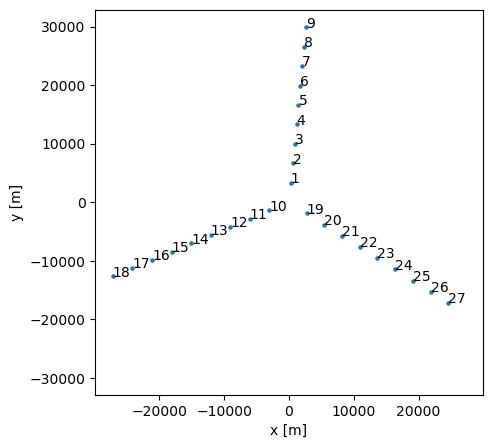

In [824]:
# Antenna parameters
x_lim = 30000
y_lim = 30000
n_antenna = 3*9
n_baselines = n_antenna*(n_antenna-1)
radius = 30000
alpha = 90-5
#arr = random_antenna_arr(n_antenna, x_lim, y_lim)
#arr = radial_antenna_arr(n_antenna, x_lim, y_lim,radius)
arr = y_antenna_arr(int(n_antenna/3), radius, alpha)
plot_antenna_arr(arr)

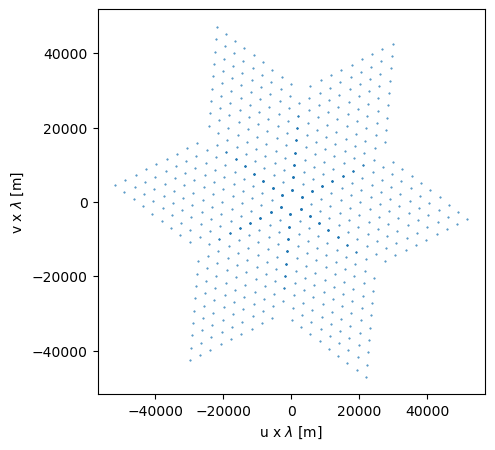

In [825]:
# Get baselines from array and plot
base_arr = get_baselines(arr)
plot_uv_plane(base_arr)

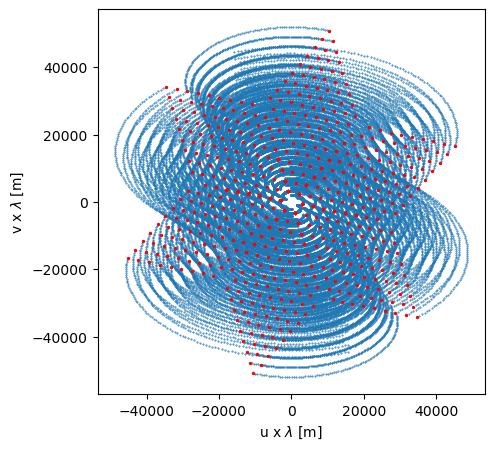

In [826]:
# Source tracking parameters
source_decl = 34/180*np.pi
array_lat = 34/180*np.pi
track_time = 8
delta_t = 5/60
t_0 = -2

# Get time integrated uv plane
track = uv_time_int(base_arr, array_lat, source_decl, track_time, delta_t, t_0)
plot_uv_plane(track, n_baselines)

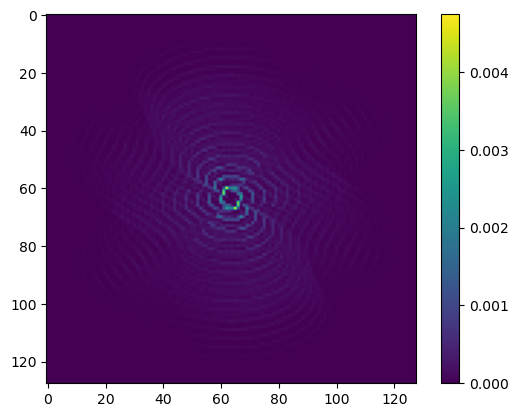

In [827]:
uv_dim = 128
uv_plane = get_uv_plane(track,uv_dim)
plt.imshow(uv_plane)
plt.colorbar()
plt.show()

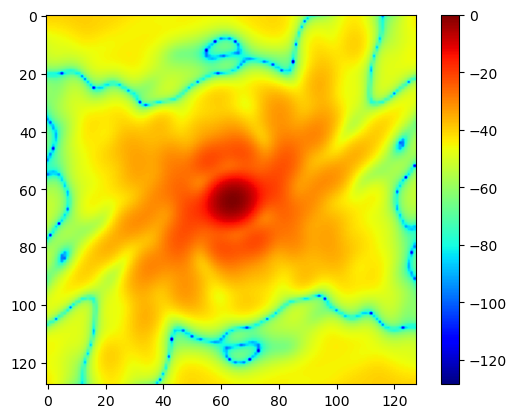

In [828]:
pad = 256
beam_crop = uv_dim
plot_beam(uv_plane, pad, beam_crop)

# Get visibilities from matrix multiplication

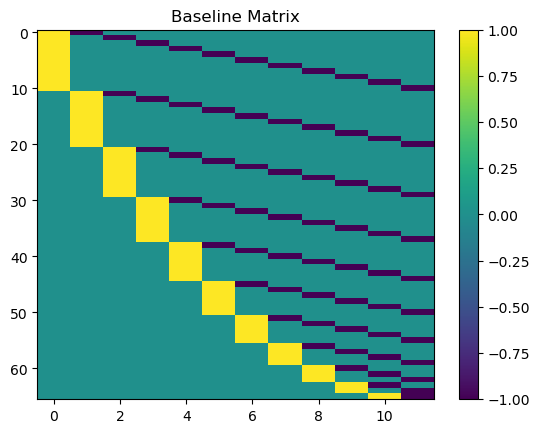

In [440]:
N = n_antenna
# Length of the baseline matrix
L = int(N*(N-1)*0.5)
B = np.zeros((L,N))
for k in range(N-1):
    for i in range(k+1):
        B[L-1-i-int(k*(k+1)/2), N-k-2]=1
        B[L-1-i-int(k*(k+1)/2), N-1-i]=-1


plt.imshow(B,aspect='auto', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Baseline Matrix')
plt.show()

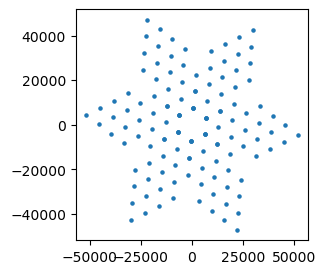

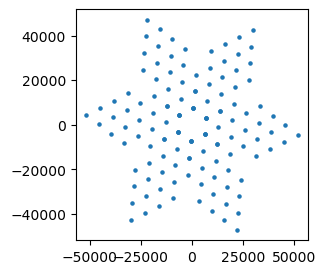

In [441]:
vis_half = B.dot(arr)
vis_full = np.concatenate((vis_half, -1*vis_half), axis=0)
plot_antenna_arr(base_arr, is_array=False)
plot_antenna_arr(vis_full, is_array=False)

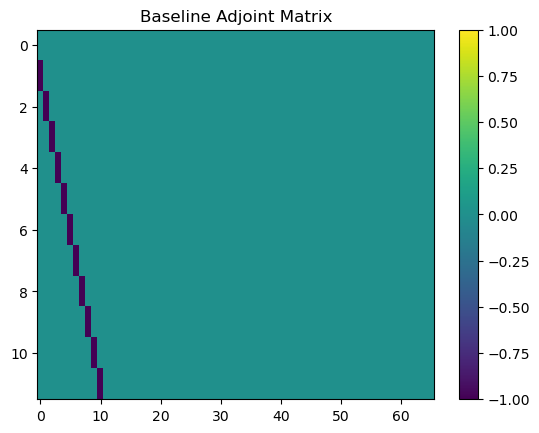

In [442]:
B_inv = np.zeros((N,L))
B_inv[1:N,:N-1] = -np.eye(N-1)

plt.imshow(B_inv,aspect='auto', vmin=-1, vmax=1)
plt.title('Baseline Adjoint Matrix')
plt.colorbar()
plt.show()

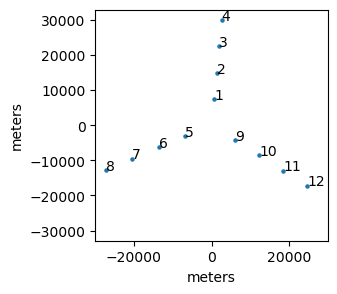

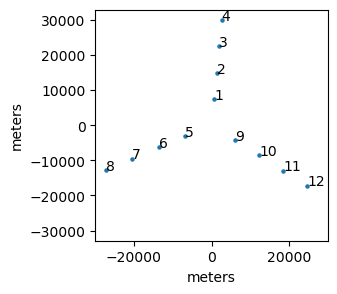

In [443]:
# rnd.shuffle(vis_half)
arr_adj = B_inv.dot(vis_half)
plot_antenna_arr(arr)
plot_antenna_arr(arr_adj+arr[0])


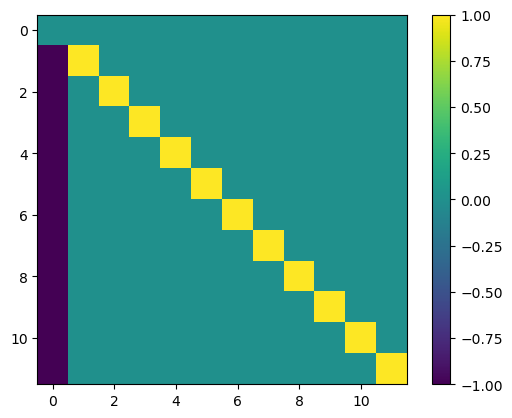

In [444]:
plt.imshow(B_inv.dot(B))
plt.colorbar()
plt.show()

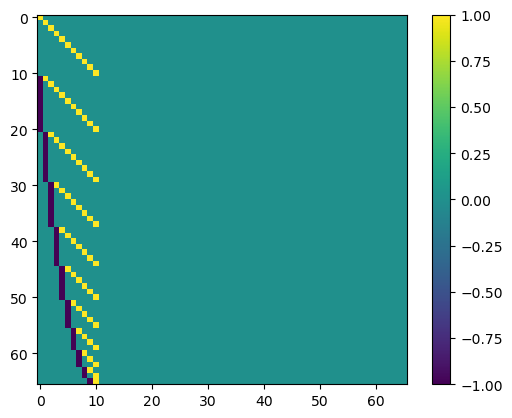

In [445]:
plt.imshow(B.dot(B_inv))
plt.colorbar()
plt.show()